# Download the Data

In [1]:
#cell 1
!pip3 install tqdm
!pip3 install pillow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 42.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


In [4]:
# Cell 2: Data Download and Extraction (Pets Dataset)

# Import necessary libraries and packages
import os           # Operating system interactions (e.g., file manipulation)
import tarfile      # Handling .tar.gz archive files
import urllib.request      # Fetching data from URLs 
import shutil       # High-level file operations (e.g., copying, moving)
import json         # Working with JSON data
import random       # Generating random numbers
import numpy as np  # Numerical operations with arrays
import boto3        # Interacting with Amazon Web Services (AWS)
import sagemaker    # SageMaker SDK for machine learning workflows

# Updated: Replace `tqdm` with `tqdm.auto` for automatic progress bar selection
from tqdm.auto import tqdm  
# Updated: Replace `sagemaker.amazon.amazon_estimator` with `sagemaker.image_uris`
from sagemaker import image_uris 
from matplotlib import pyplot as plt  # Plotting and visualization
from xml.etree import ElementTree as ET  # Parsing XML (used for annotations)
from PIL import Image, ImageDraw, ImageFont  # Image manipulation and drawing


# URLs for the Pets dataset (images and annotations)
urls = [
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz",
]

# Function to download and extract data from URLs
def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split("/")[-1]  # Get the filename from the URL

        # Check if file already exists
        if target_file not in os.listdir(download_dir):
            print("Downloading", url)  # Indicate download progress

            # Use urllib.request for fetching data
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))

            # Open the tar.gz file
            with tarfile.open(target_file) as tf:  # Use context manager for automatic file closing
                tf.extractall(data_dir)  # Extract files to the data directory

        else:
            print("Already downloaded", url)  # Skip downloading if the file is present


# Create the 'data' directory if it doesn't exist
if not os.path.isdir("data"):
    os.mkdir("data")

# Download and extract the Pets dataset to the 'data' directory
download_and_extract("data", ".")  # '.' represents the current directory

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Extracting Annotations from XML Format

In [5]:
# Cell 3: Exploring the XML Annotations (Pets Dataset)

# Set the directory path where XML annotation files are stored
xml_dir = "data/annotations/xmls/"  

# Create a list of all XML file paths in the directory
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == "xml"]

# Print the path of the first XML file found in the directory
xml_files[0]  

'data/annotations/xmls/leonberger_116.xml'

In [6]:
# Cell 4: Define Object Classes and Categories (Pets Dataset)

# List of class names for the object detection task
classes = ["cat", "dog"]  

# List of dictionaries defining the categories and their IDs
categories = [
    {"class_id": 0, "name": "cat"},  
    {"class_id": 1, "name": "dog"},
]

In [7]:
# Cell 5: XML Annotation Extraction for Object Detection (Pets Dataset)

from xml.etree import ElementTree as ET  # Ensure the necessary library is imported


def extract_annotation(xml_file_path):
    """
    Extracts relevant annotation information from an XML file (in PASCAL VOC format).
    
    Args:
        xml_file_path (str): The path to the XML annotation file.

    Returns:
        dict: A dictionary containing the extracted annotation data.
    """

    tree = ET.parse(xml_file_path)  # Parse the XML file using ElementTree
    root = tree.getroot()  # Get the root element of the XML tree

    # Initialize an empty dictionary to store the annotation data
    annotation = {} 

    # Extract the filename and add it to the dictionary
    annotation["file"] = root.find("filename").text 

    # Add categories information (same for all annotations)
    annotation["categories"] = categories  # This assumes the 'categories' variable is defined elsewhere

    # Extract image size information
    size = root.find("size")
    annotation["image_size"] = [
        {
            "width": int(size.find("width").text),
            "height": int(size.find("height").text),
            "depth": int(size.find("depth").text),
        }
    ]

    # Create an empty list to store bounding box annotations
    annotation["annotations"] = []

    # Iterate over all objects in the XML
    for item in root.iter("object"):
        # Find the class ID corresponding to the object's name (e.g., 'cat', 'dog')
        class_id = classes.index(item.find("name").text)

        # Initialize variables for bounding box coordinates
        xmin, ymin, xmax, ymax = None, None, None, None  # Initialize to None in case coordinates are not found

        # Find the bounding box coordinates within the object
        for box in item.findall("bndbox"):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)

        # Check if all coordinates are found before adding the annotation
        if all([xmin, ymin, xmax, ymax]):  
            annotation["annotations"].append(
                {
                    "class_id": class_id,
                    "left": xmin,
                    "top": ymin,
                    "width": xmax - xmin,  # Calculate width
                    "height": ymax - ymin,  # Calculate height
                }
            )

    return annotation  # Return the extracted annotation dictionary

In [8]:
# cell 6
extract_annotation(xml_files[0])

{'file': 'leonberger_116.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 489, 'height': 500, 'depth': 3}],
 'annotations': [{'class_id': 1,
   'left': 49,
   'top': 36,
   'width': 163,
   'height': 197}]}

# Visualize Data

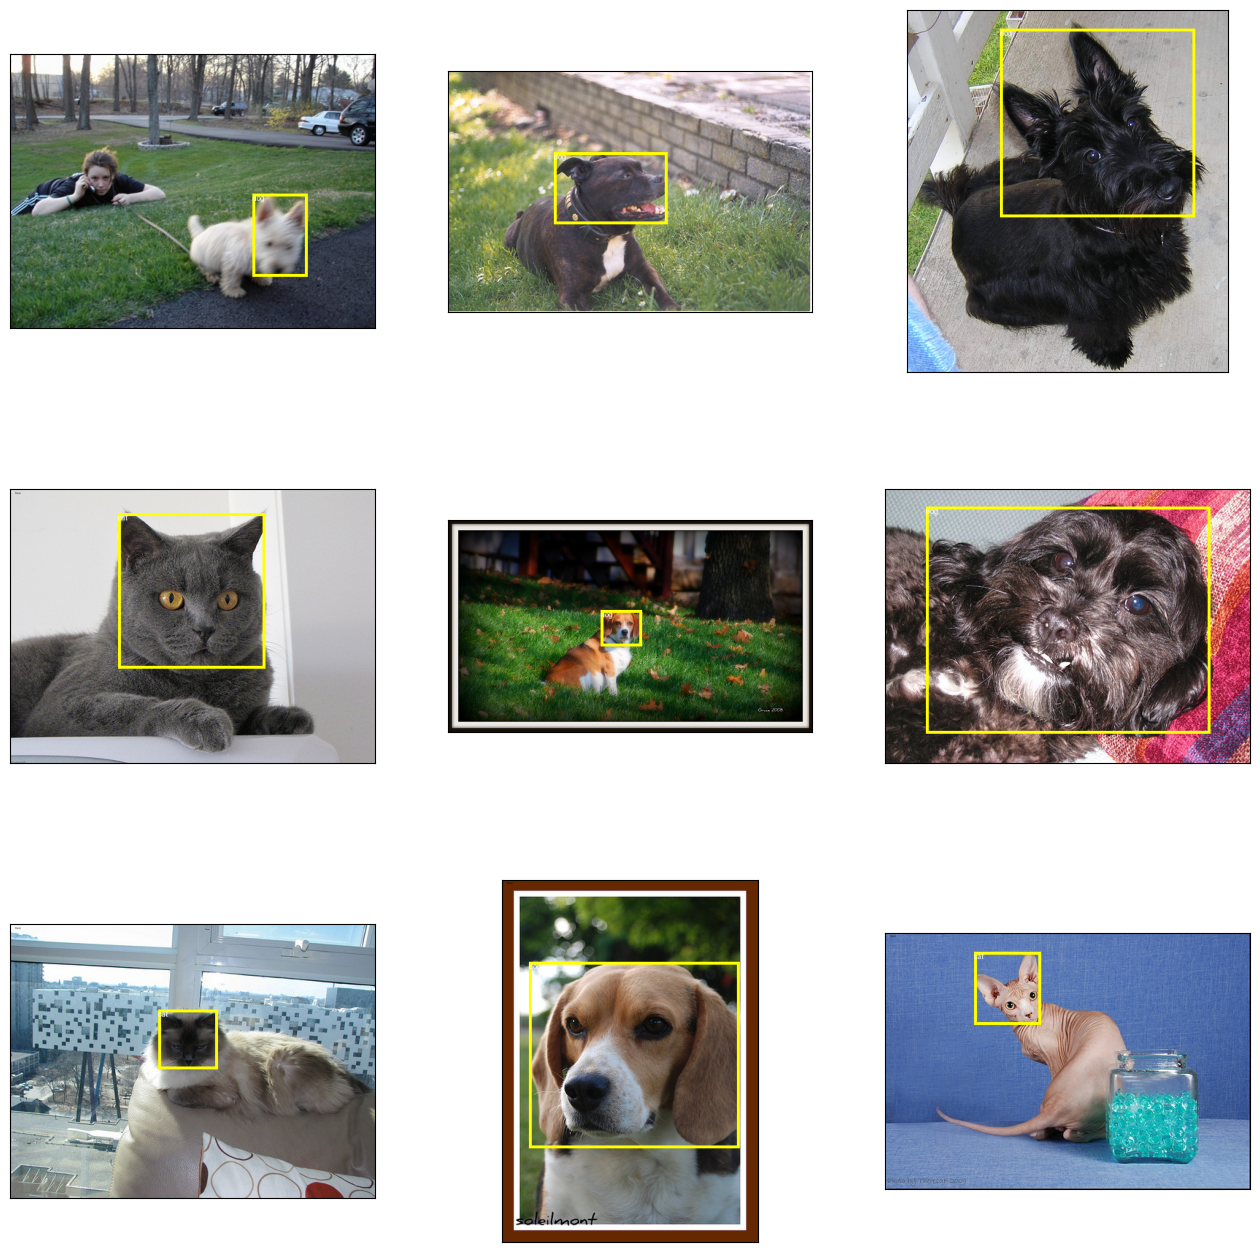

In [9]:
# Cell 7: Visualizing Image Annotations (Pets Dataset)

from PIL import Image, ImageDraw, ImageFont  # Ensure necessary libraries are imported
from matplotlib import pyplot as plt         # ...

# Function to plot an image with bounding boxes and labels
def plot_example(plt, annot, image_file_path, rows, cols, index):
    """
    Plots an image with bounding boxes and class labels from an annotation.

    Args:
        plt: The Matplotlib pyplot object to use for plotting.
        annot (dict): The annotation dictionary containing image information and annotations.
        image_file_path (str): The path to the image file.
        rows (int): Number of rows in the subplot grid.
        cols (int): Number of columns in the subplot grid.
        index (int): The index of the subplot to place the plot.

    Returns:
        plt: The updated Matplotlib pyplot object after plotting.
    """
    img = Image.open(image_file_path)  # Open the image file
    draw = ImageDraw.Draw(img)  # Create a drawing object to draw on the image

    # Try to load the specified font or fall back to a default
    try:
        font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf", 20)
    except OSError:  # If the font is not found
        font = ImageFont.load_default()  # Load the default font 

    # Draw bounding boxes and labels for each annotation
    for a in annot["annotations"]:
        box = [
            int(a["left"]),
            int(a["top"]),
            int(a["left"]) + int(a["width"]),  # Calculate bottom-right x
            int(a["top"]) + int(a["height"]),  # Calculate bottom-right y
        ]

        # Draw the bounding box
        draw.rectangle(box, outline="yellow", width=4)  

        # Draw the class label on the top-left corner of the box
        draw.text((box[0], box[1]), classes[int(a["class_id"])], font=font)  

    # Create a subplot and display the image
    plt.subplot(rows, cols, index + 1)  # Add 1 to index for 1-based indexing
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.imshow(img)  # Display the image in the subplot
    return plt


# Function to show a grid of random images with their annotations
def show_random_annotations(plt):
    """
    Displays a grid of random images with their annotations.
    """
    plt.figure(figsize=(16, 16))  # Create a 16x16 figure

    for i in range(9):  # Display 9 random images
        index = random.randint(0, len(xml_files) - 1)  # Choose a random XML file

        # Extract annotation and get image file path
        annot = extract_annotation(xml_files[index])  
        image_file_path = os.path.join("data/images/", annot["file"])

        # Plot the image and annotations using the helper function
        plt = plot_example(plt, annot, image_file_path, 3, 3, i)

    plt.show()  # Show the combined plot


# Call the function to display random annotated images
show_random_annotations(plt)

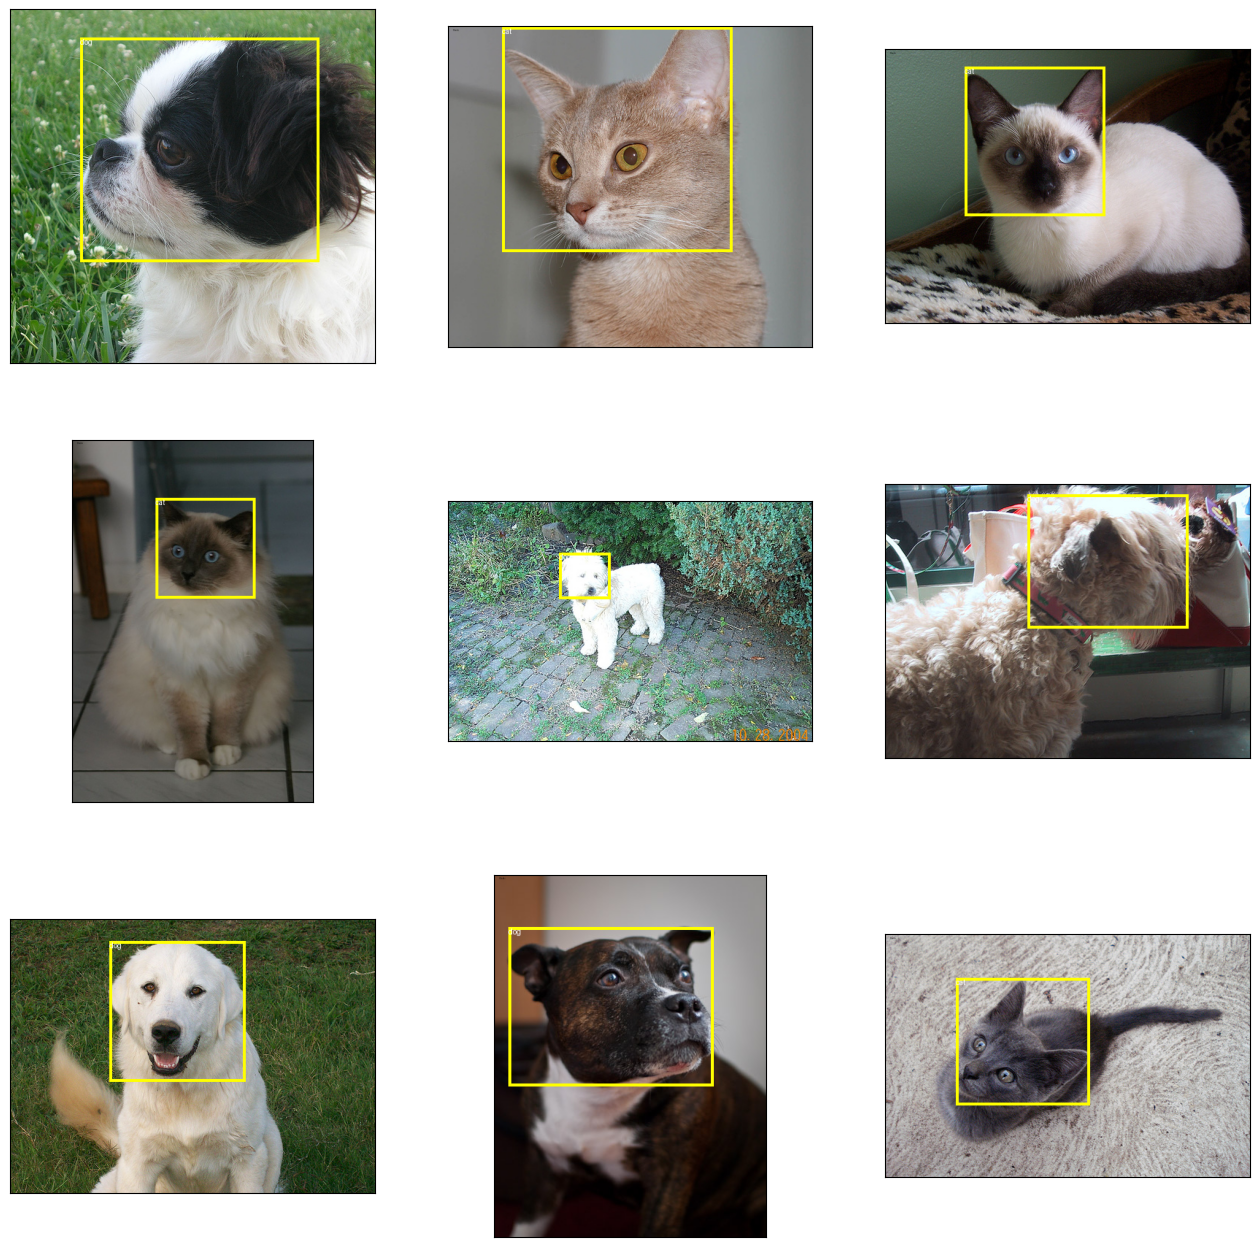

In [10]:
#cell 8
show_random_annotations(plt)

# SageMaker Setup

In [11]:
import sagemaker
from sagemaker import image_uris  # Import the image_uris module for getting container URIs
import boto3  # Ensure boto3 is imported for AWS interactions

# Get the IAM role associated with the current SageMaker notebook
role = sagemaker.get_execution_role()

# Specify the S3 bucket where you will store training data and model artifacts
bucket_name = "petsdataod"

# Get the URI of the latest object detection Docker image from SageMaker's registry
# (Updated to use image_uris)
training_image = image_uris.retrieve(framework="object-detection", region=boto3.Session().region_name, version="latest")

# Print the training image URI for confirmation
print(training_image) 

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:1


In [12]:
# Cell 10: Create and Clear Data Folders for Object Detection

import os
import shutil

# List of folder names to be used for organizing training and validation data
folders = ["train", "train_annotation", "validation", "validation_annotation"]

# Iterate over the list of folder names
for folder in folders:
    # Check if the folder already exists
    if os.path.isdir(folder):
        # If it exists, remove it and its contents (careful with this!)
        shutil.rmtree(folder)
    # Create a new, empty folder with the same name
    os.mkdir(folder)

# Preparing Data for SageMaker

In [13]:
# Cell 11: Count Total Number of Examples

# Print the total number of XML annotation files 
print("Total examples:", len(xml_files))

Total examples: 3686


In [14]:
import json
import random
import shutil
from tqdm.auto import tqdm  # Import tqdm.auto for enhanced progress bar

# Iterate over each XML file path in the xml_files list
for xml_file in tqdm(xml_files):  
    # Randomly assign the image and annotation to either 'train' or 'validation' set
    # With a 75% probability of being assigned to the 'train' set
    target_set = "train" if random.randint(0, 99) < 75 else "validation"

    # Extract the annotation information from the XML file
    annot = extract_annotation(xml_file)

    # Construct the original path to the image file (from the 'data/images' folder)
    image_file_path = os.path.join("data/images/", annot["file"])

    # Construct the target path for the image file (in the 'train' or 'validation' folder)
    image_target_path = os.path.join(target_set, annot["file"])

    # Copy the image file to the appropriate target folder
    shutil.copy(image_file_path, image_target_path)

    # Construct the target path for the JSON annotation file
    json_file_path = os.path.join(target_set + "_annotation", annot["file"][:-3] + "json")

    # Save the annotation dictionary as a JSON file
    with open(json_file_path, "w") as f:
        json.dump(annot, f)

  0%|          | 0/3686 [00:00<?, ?it/s]

In [17]:
# Cell 13: Listing Training Images and Annotations

import os

# Get a list of all image filenames in the 'train' directory
train_images = os.listdir("train")  

# Get a list of all annotation filenames in the 'train_annotation' directory
train_annots = os.listdir("train_annotation")

In [18]:
#cell 14
print(len(train_annots), len(train_images))

2790 2790


In [19]:
# Cell 15: Check for Missing Annotations in Training Data

import os
# Iterate over each image filename in the 'train_images' list
for image in train_images:
    # Extract the filename without the extension (e.g., 'cat1' from 'cat1.jpg')
    key = image.split(".")[0] 

    # Construct the expected JSON annotation filename (e.g., 'cat1.json')
    json_file = key + ".json"  

    # Check if the JSON annotation file exists in the 'train_annotation' directory
    if json_file not in train_annots:  
        # Print a message if the JSON annotation file is not found
        print("Not found", json_file) 


# Uploading Data to S3

In [21]:
#cell 16
# Cell 16: Upload Data to S3 for SageMaker Training

#%%time  # Measure the execution time of this cell

import sagemaker

# Create a SageMaker session to interact with SageMaker resources
sess = sagemaker.Session()  

print("Uploading data..")

# Upload training images to S3
s3_train_path = sess.upload_data(
    path="train", bucket=bucket_name, key_prefix="train"
)
print("Training images uploaded")

# Upload training annotations to S3
s3_train_annotation_path = sess.upload_data(
    path="train_annotation", bucket=bucket_name, key_prefix="train_annotation"
)
print("Training Annotations uploaded")

# Upload validation images to S3
s3_validation_path = sess.upload_data(
    path="validation", bucket=bucket_name, key_prefix="validation"
)
print("Validation images uploaded")

# Upload validation annotations to S3
s3_validation_annotation_path = sess.upload_data(
    path="validation_annotation", bucket=bucket_name, key_prefix="validation_annotation"
)
print("Validation Annotations uploaded")

Uploading data..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded


In [22]:
# Cell 17: Retrieve the S3 Path to Validation Annotations

s3_validation_annotation_path

's3://petsdataod/validation_annotation'

# SageMaker Estimator

In [29]:
# Cell 18: Define SageMaker Estimator for Object Detection Training

import sagemaker

# Create a SageMaker estimator object
model = sagemaker.estimator.Estimator(
    image_uri=training_image,             # (Updated: Use image_uri instead of training_image)
    role=role,                               # IAM role for SageMaker permissions
    instance_count=1,                       # Number of training instances to use
    instance_type="ml.p3.2xlarge",           # Type of EC2 instance for training (GPU-accelerated)
    train_volume_size=100,                   # Size in GB of the EBS volume for storing training data
    train_max_run=36000,                     # Maximum runtime for the training job in seconds (10 hours)
    input_mode="File",                       # Input mode (File for loading data from S3)
    output_path="s3://petsdataod/output",      # S3 path to store model artifacts
    sagemaker_session=sess,                 # SageMaker Session object for managing the job
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Hyperparameters

In [30]:
# Cell 19: Set Hyperparameters for Object Detection Training

# Set hyperparameters for the SageMaker object detection estimator
model.set_hyperparameters(
    base_network="resnet-50",  # Base convolutional neural network architecture
    num_classes=2,  # Number of object classes to detect
    use_pretrained_model=1,  # Use pre-trained weights on ImageNet (1 for True, 0 for False)
    mini_batch_size=16,  # Number of images in each training batch
    epochs=15,  # Number of times the model will iterate over the entire dataset
    learning_rate=0.001,  # Initial learning rate for the optimizer
    lr_scheduler_step="10",  # Step (in epochs) to reduce the learning rate
    lr_scheduler_factor=0.1,  # Factor by which to reduce the learning rate
    optimizer="sgd",  # Optimization algorithm (Stochastic Gradient Descent)
    momentum=0.9,  # Momentum factor for SGD
    weight_decay=0.0005,  # Weight decay (L2 regularization) factor
    overlap_threshold=0.5,  # Overlap threshold for non-max suppression
    nms_threshold=0.45,  # Non-maximum suppression (NMS) threshold
    image_shape=512,  # Input image size (square)
    num_training_samples=len(train_annots),  # Number of training examples
)

# Data Channels

In [31]:
# Cell 20: Configure Training and Validation Data Channels for SageMaker

import sagemaker

# Create SageMaker training data channels for images and annotations
train_data = sagemaker.inputs.TrainingInput(
    s3_train_path, 
    distribution="FullyReplicated",  # Copy data to all nodes for faster training
    content_type="application/x-image",  # Specify image content type
    s3_data_type="S3Prefix"  # Indicate that data is stored in a directory prefix
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_path, 
    distribution="FullyReplicated",
    content_type="application/x-image",
    s3_data_type="S3Prefix"
)

# Create SageMaker training data channels for annotations
train_annotation_data = sagemaker.inputs.TrainingInput(
    s3_train_annotation_path, 
    distribution="FullyReplicated",
    content_type="application/x-image",  # This should be 'application/json'
    s3_data_type="S3Prefix"
)
validation_annotation_data = sagemaker.inputs.TrainingInput(
    s3_validation_annotation_path, 
    distribution="FullyReplicated",
    content_type="application/x-image",  # This should be 'application/json'
    s3_data_type="S3Prefix"
)

In [32]:
# Cell 21: Create Data Channels Dictionary for SageMaker Training

# Create a dictionary mapping channel names to SageMaker data channel objects
data_channels = {
    "train": train_data,
    "train_annotation": train_annotation_data,
    "validation": validation_data,
    "validation_annotation": validation_annotation_data,
}
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7fd99930f460>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7fd99930fe80>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7fd99930feb0>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7fd99930f220>}

# Model Training

In [33]:
# Cell 22: Start SageMaker Object Detection Training Job

# Start the training job by calling fit() on the estimator
model.fit(inputs=data_channels, logs=True)  


INFO:sagemaker:Creating training-job with name: object-detection-2024-07-01-00-52-05-986


2024-07-01 00:52:06 Starting - Starting the training job...
2024-07-01 00:52:31 Starting - Preparing the instances for training...
2024-07-01 00:53:04 Downloading - Downloading input data......
2024-07-01 00:54:03 Downloading - Downloading the training image......
2024-07-01 00:55:04 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Mon Jul  1 00:55:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage

# Deploy Model

In [34]:
# Cell 23: Deploy the Trained Object Detection Model

# Deploy the trained model
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge') 

# Print a confirmation message
print('\nModel deployed!') 

INFO:sagemaker:Creating model with name: object-detection-2024-07-01-01-13-18-877
INFO:sagemaker:Creating endpoint-config with name object-detection-2024-07-01-01-13-18-877
INFO:sagemaker:Creating endpoint with name object-detection-2024-07-01-01-13-18-877


--------!
Model deployed!


# Predictions

In [54]:
# Cell 24: List Validation Images for Object Detection

import os

# Specify the directory containing validation images
image_dir = "validation"

# Create a list of all image filenames in the validation directory that end with '.jpg'
images = [x for x in os.listdir(image_dir) if x[-3:] == "jpg"]

# Print the total number of validation images found
print(len(images)) 

896


In [55]:
# Cell 25: Set Content Type for Model Inference

# Set the content type for the deployed SageMaker model
deployed_model.content_type = "image/jpeg" 

In [108]:
# Cell 26: Perform Object Detection on a Sample Validation Image

import os
import json

# Select an index for an image in the validation set 
index = 90
# You can change the index (0, 1, 2, ...) to try different validation images

# Get the path to the selected image file
image_path = 'dog_cat.jfif'
image_path = os.path.join(image_dir, images[index])

# Open the image file in binary read mode
with open(image_path, "rb") as f:
    # Read the image data as bytes
    b = bytearray(f.read())  

# Make a prediction on the image using the deployed model
# (This assumes 'deployed_model' was created in a previous cell)
results = deployed_model.predict(b)  

# Parse the JSON prediction results returned by the model
results = json.loads(results) 

# Extract the list of predicted bounding boxes and class labels
preds = results["prediction"] 

In [109]:
# Cell 27: Inspect the Object Detection Predictions

preds 

[[1.0,
  0.9300143718719482,
  0.09434571862220764,
  0.08114543557167053,
  0.35032007098197937,
  0.34783998131752014],
 [1.0,
  0.18850214779376984,
  0.08856988698244095,
  0.12536877393722534,
  0.2534935176372528,
  0.2902153730392456],
 [1.0,
  0.13594430685043335,
  0.1154765784740448,
  0.044759273529052734,
  0.8885502815246582,
  0.8850479125976562],
 [1.0,
  0.09702247381210327,
  0.19756272435188293,
  0.12660185992717743,
  0.34091606736183167,
  0.2826586365699768],
 [1.0,
  0.04726744070649147,
  0.12665168941020966,
  0.045945197343826294,
  0.42797356843948364,
  0.48441484570503235],
 [1.0,
  0.042706601321697235,
  0.25131264328956604,
  0.16088253259658813,
  0.33500561118125916,
  0.29249101877212524],
 [1.0,
  0.04163432493805885,
  0.7936399579048157,
  0.7598082423210144,
  0.8669151663780212,
  0.8902369141578674],
 [1.0,
  0.03953292593359947,
  0.3489859104156494,
  0.052137166261672974,
  0.48708105087280273,
  0.22346824407577515],
 [1.0, 0.039334949105978

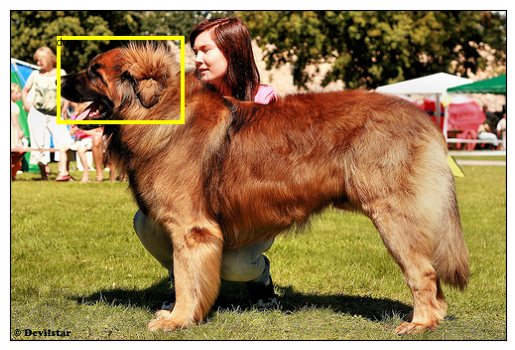

In [110]:
# Cell 28: Visualize Object Detection Predictions on the Image

from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

# Load the image for visualization
img = Image.open(image_path)
draw = ImageDraw.Draw(img)  # Create a drawing object on the image

# Load the desired font or default to the system font if not found
try:
    font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf", 30)
except OSError:
    font = ImageFont.load_default()

# Get the width and height of the image
w, h = img.size

# Iterate through the predictions (bounding boxes and class IDs)
for pred in preds:
    # Unpack the prediction data (including class_id)
    class_id, score, xmin, ymin, xmax, ymax = pred  # Unpack class_id here

    # Only process predictions with a confidence score above a certain threshold
    if score > 0.7:
        # Scale the bounding box coordinates to the image dimensions
        box = [w * xmin, h * ymin, w * xmax, h * ymax]

        # Draw the bounding box on the image in yellow with a width of 4 pixels
        draw.rectangle(box, outline="yellow", width=4)

        # Convert the class ID to the corresponding class label
        class_label = classes[int(class_id)]

        # Draw the class label at the top-left corner of the bounding box
        draw.text((box[0], box[1]), class_label, font=font, fill="#000000")

# Set up Matplotlib plot for visualization
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks

# Display the annotated image
plt.imshow(img)
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
#cell 29
sagemaker.Session().delete_endpoint(deployed_model.endpoint)